In [1]:
import sys
from tqdm import tqdm
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from data.energy_data import EnergyDataset
from models.lstm import LSTM

In [2]:
timeseries = pd.read_csv('../data/data_preprocessed.csv')
timeseries = timeseries[['_value']]

In [3]:
train_dataset = EnergyDataset('../data/train.csv', window_size=4)
test_dataset = EnergyDataset('../data/test.csv', window_size=4)

train_loader = DataLoader(train_dataset, batch_size=8, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, drop_last=True, shuffle=False)

In [4]:
model = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1)
optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss()

In [5]:
n_epochs = 100

for i in range(n_epochs):
    model.train()
    for x_batch, y_batch in tqdm(train_loader):
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        model.eval()
        with torch.no_grad():
            mse_list = []
            for x_test, y_test in test_loader:
                with torch.no_grad():
                    y_pred = model(x_test)
                    train_rmse = np.sqrt(loss_function(y_pred, y_test))
                    y_pred = model(x_batch)
                    loss = loss_function(y_pred, y_test).item()
                    mse_list.append(loss)
            
            mse = sum(mse_list) / len(mse_list)
            print("Epoch %d: test MSE %.4f" % (i, mse))


100%|██████████| 3400/3400 [00:05<00:00, 574.63it/s]


Epoch 0: test MSE 0.0399


100%|██████████| 3400/3400 [00:05<00:00, 602.52it/s]


Epoch 10: test MSE 0.0301


100%|██████████| 3400/3400 [00:06<00:00, 526.80it/s]


Epoch 20: test MSE 0.0298


100%|██████████| 3400/3400 [00:05<00:00, 654.67it/s]


Epoch 30: test MSE 0.0470


100%|██████████| 3400/3400 [00:05<00:00, 584.64it/s]


Epoch 40: test MSE 0.1079


100%|██████████| 3400/3400 [00:04<00:00, 687.79it/s]


Epoch 50: test MSE 0.0316


100%|██████████| 3400/3400 [00:06<00:00, 528.33it/s]


Epoch 60: test MSE 0.0292


100%|██████████| 3400/3400 [00:05<00:00, 625.41it/s]


Epoch 70: test MSE 0.0351


100%|██████████| 3400/3400 [00:05<00:00, 584.63it/s]


Epoch 80: test MSE 0.0481


100%|██████████| 3400/3400 [00:05<00:00, 672.75it/s]


Epoch 90: test MSE 0.0233


100%|██████████| 3400/3400 [00:05<00:00, 627.55it/s]


In [6]:
X_train, y_train = train_dataset.return_X_y()
X_test, y_test = test_dataset.return_X_y()

with torch.no_grad():
    # shift train predictions for plotting
    y_pred_train = model(X_train)[:,-1,:]
    y_pred_test = model(X_test)[:,-1,:]

print(y_pred_train.shape, y_pred_test.shape, y_pred_test.shape[0] + y_pred_train.shape[0])

torch.Size([27202, 1]) torch.Size([6798, 1]) 34000


In [7]:
model(X_test).shape

torch.Size([6798, 4, 1])

In [8]:
y_pred = torch.cat([y_pred_train, y_pred_test], dim=0)
y_pred.shape

torch.Size([34000, 1])

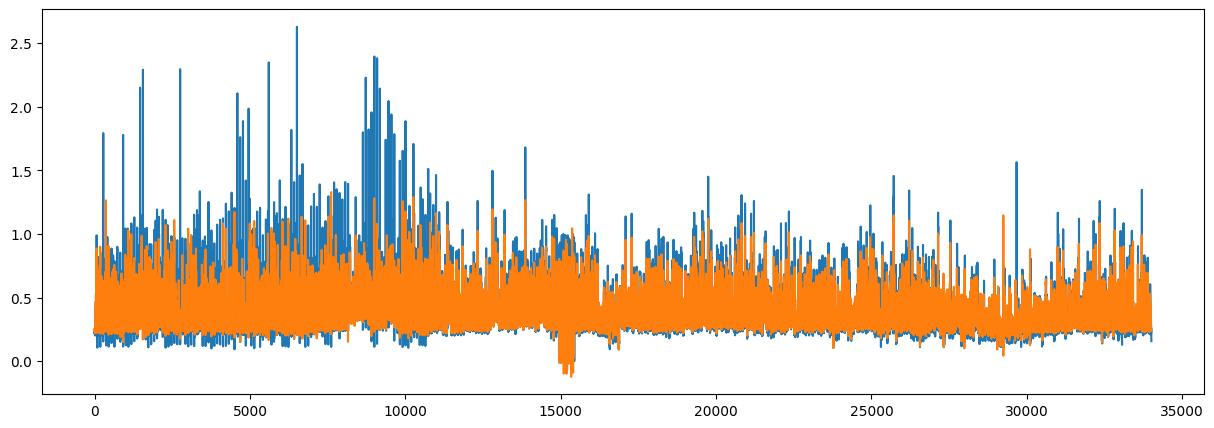

In [9]:
plt.figure(figsize=(15,5))

plt.plot(timeseries)
plt.plot(y_pred)

In [ ]:
y_test = pd.read_csv('../data/test.csv')[['_value']]
y_train = pd.read_csv('../data/train.csv')[['_value']]

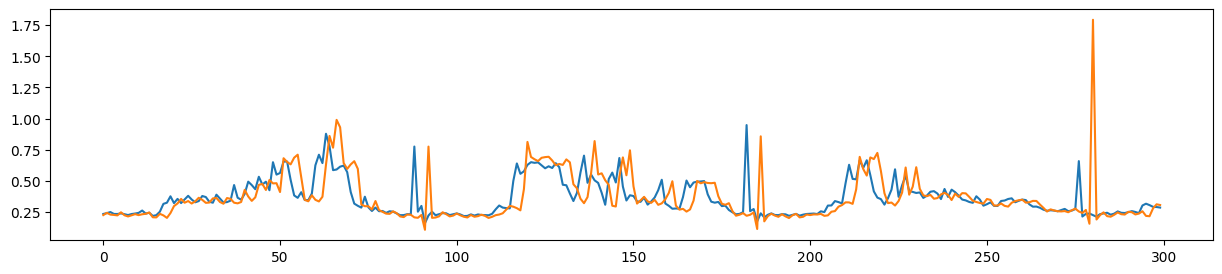

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(y_pred_train[:300])
plt.plot(y_train[:300])

In [ ]:
torch.save(model.state_dict(), '../saved_models/lstm_w4.pt')